In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import RegularGridInterpolator

In [2]:
def rk4(f,y0,dt,n,gamma):
  t = np.linspace(0, n * dt, n + 1)
  y = np.zeros((n+1, len(y0)))
  y[0] = y0
  for i in range(n):
    k1 = dt * f(t[i], y[i],gamma)
    k2 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k1,gamma)
    k3 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k2,gamma)
    k4 = dt * f(t[i] + dt, y[i] + k3,gamma)
    y[i + 1] = y[i] + (1/6) * (k1 + 2 * k2 + 2 * k3 + k4)
  return y,t

In [3]:
#Dispersion relation
R_dim = 30e3
R_nondim = R_dim/300e3
beta_dim = 2e-12
beta_nondim = beta_dim * 86400 * 300e3

#Fourier harmonics
S = 10 #spectral radius
N = 41

def omega(k,l):
    return -beta_nondim * k / (k**2 + l**2 + R_nondim**-2)

P = 5 #radius of peak
H = 0.08 #height of peak (max amplitude)

def A(k,l):
  return H * np.exp(-0.5*(k**2+l**2-P**2)**2/(2*P**2))

In [38]:
k,l = np.linspace(-S,S,N),np.linspace(-S,S,N)
K,L = np.meshgrid(k,l)
np.random.seed(0)
phi = np.random.uniform(0,2*np.pi,size=(N,N))
omega_vals = omega(K,L)
A_vals = A(K,L)

def modulo_grid(x, y):
  x_mod = np.mod(x + np.pi, 2 * np.pi) - np.pi
  y_mod = np.mod(y + np.pi, 2 * np.pi) - np.pi
  return x_mod, y_mod

def psi(t,pos):
  x_mod,y_mod = modulo_grid(*pos)
  psi = np.real(np.sum(A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  return psi

def f(t,pos,gamma):
  x_mod,y_mod = modulo_grid(*pos)
  dpsi_dx = np.real(np.sum(1j*K*A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))
  dpsi_dy = np.real(np.sum(1j*L*A_vals*np.exp(1j*(K*x_mod + L*y_mod - omega_vals*t + phi))))

  dphi_dx = dpsi_dx
  dphi_dy = dpsi_dy

  u = gamma * dphi_dx - (1-gamma) * dpsi_dy
  v = gamma * dphi_dy + (1-gamma) * dpsi_dx

  return np.array([u,v])

In [45]:
X = np.linspace(-np.pi,np.pi,50)
Y = np.linspace(-np.pi,np.pi,50)
T = np.linspace(0,500,1)
U = np.zeros((len(T),len(X),len(Y)))
V = np.zeros((len(T),len(X),len(Y)))
PSI = np.zeros((len(T),len(X),len(Y)))
gamma = 0.05
for k in range(len(T)):
  for i in range(len(X)):
    for j in range(len(Y)):
      U[k,i,j],V[k,i,j] = f(T[k],(X[i],Y[j]),gamma)
      PSI[k,i,j] = psi(T[k],(X[i],Y[j]))

In [48]:
u_interp = RegularGridInterpolator((T, X, Y), U)
v_interp = RegularGridInterpolator((T, X, Y), V)

def f_interp(t,pos):
  #Interpolate value from U,V.
  x_mod, y_mod = modulo_grid(*pos)
  dx = -u_interp([t,x_mod, y_mod])[0]
  dy = v_interp([t,x_mod, y_mod])[0]
  return np.array([dx,dy])

In [ ]:
#New RK4 without gamma for use with interpolated f
def rk4(f,y0,dt,n):
  t = np.linspace(0, n * dt, n + 1)
  y = np.zeros((n+1, len(y0)))
  y[0] = y0
  for i in range(n):
    k1 = dt * f(t[i], y[i])
    k2 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k1)
    k3 = dt * f(t[i] + 0.5 * dt, y[i] + 0.5 * k2)
    k4 = dt * f(t[i] + dt, y[i] + k3)
    y[i + 1] = y[i] + (1/6) * (k1 + 2 * k2 + 2 * k3 + k4)
  return y,t

In [49]:
#Single trajectory
y0 = [2,1]
dt = 1/24 #time step 1 hour
n = 10000 #number of timesteps
y,t = rk4(f_interp,y0,dt,n,0.01)

TypeError: f_interp() takes 2 positional arguments but 3 were given

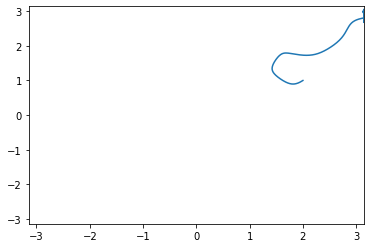

In [42]:
#Plot absolute trajectory
plt.plot(y[:,0],y[:,1])
plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)

plt.show()

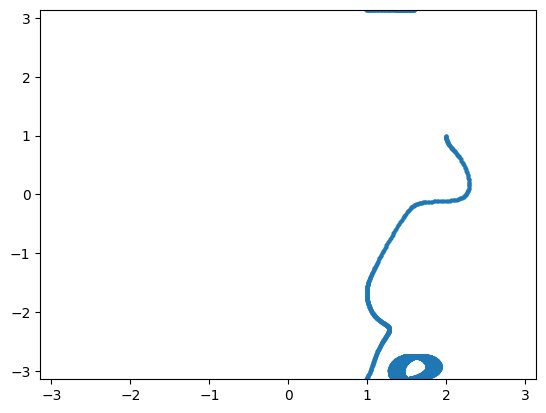

(10001, 2)

In [12]:
#Plot the pseudo trajectory (modulo the basin)
mod_path = np.apply_along_axis(lambda col: modulo_grid(col[0], col[1]), axis=1, arr=y)
plt.scatter(mod_path[:,0],mod_path[:,1],s=4)

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()




In [14]:
#Randomly select initial points
np.random.seed(42)
num_points = 100
x_coords = np.random.uniform(-np.pi, np.pi, num_points)
y_coords = np.random.uniform(-np.pi, np.pi, num_points)
initial_conditions = np.column_stack((x_coords, y_coords))

n = 10000
dt = 1/2 #time step half day

gamma = 0
solutions = []
for y0 in initial_conditions:
  sol,t = rk4(f,y0,dt,n,gamma)
  solutions.append(sol)

with open('gamma0.pickle', 'wb') as file:
    pickle.dump(solutions, file)

solutions = []
gamma = 0.05
for y0 in initial_conditions:
  sol,t = rk4(f,y0,dt,n,gamma)
  solutions.append(sol)

with open('gamma005.pickle', 'wb') as file:
    pickle.dump(solutions, file)

solutions = []
gamma = 1
for y0 in initial_conditions:
  sol,t = rk4(f,y0,dt,n,gamma)
  solutions.append(sol)

with open('gamma1.pickle', 'wb') as file:
    pickle.dump(solutions, file)



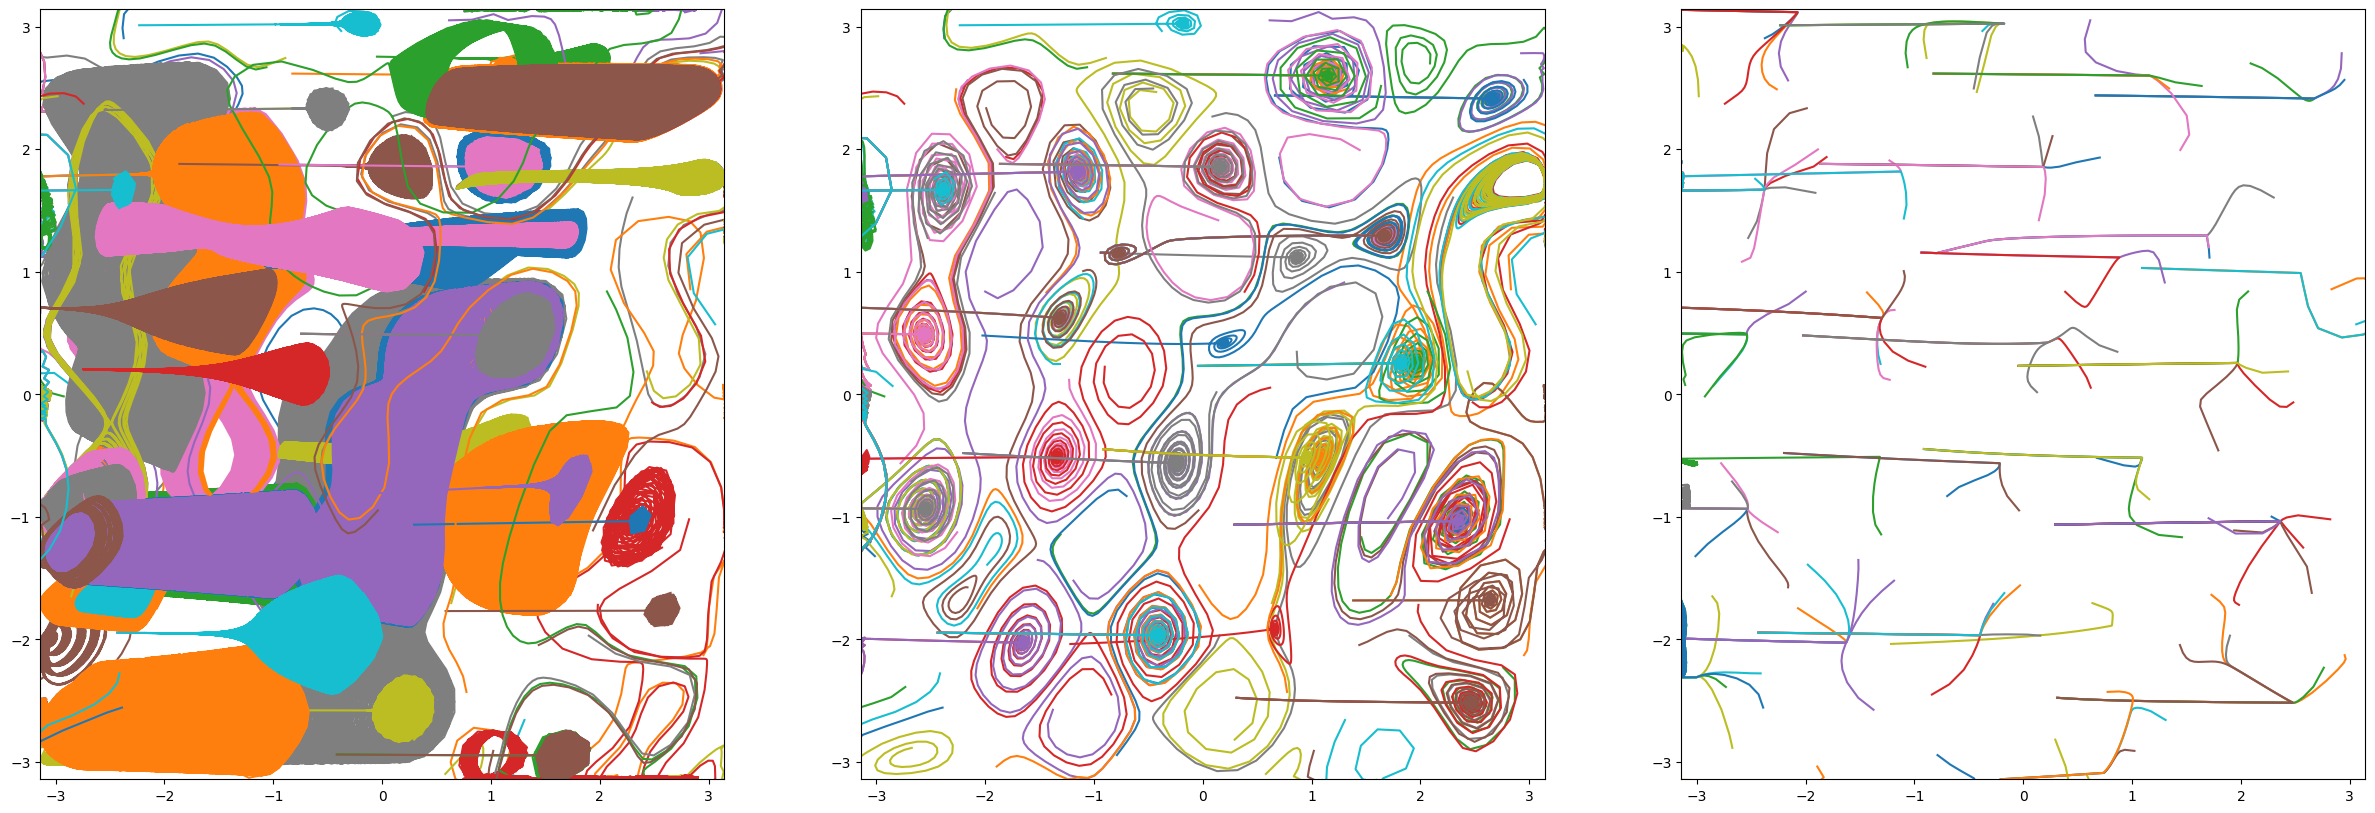

In [18]:
sols = ['gamma0.pickle','gamma005.pickle','gamma1.pickle']
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(30,10))

for i,ax in enumerate([ax1,ax2,ax3]):
  ax.set_xlim(-np.pi, np.pi)
  ax.set_ylim(-np.pi, np.pi)
  with open(sols[i], 'rb') as file:
    solutions = pickle.load(file)
    for sol in solutions:
      ax.plot(sol[:,0],sol[:,1])



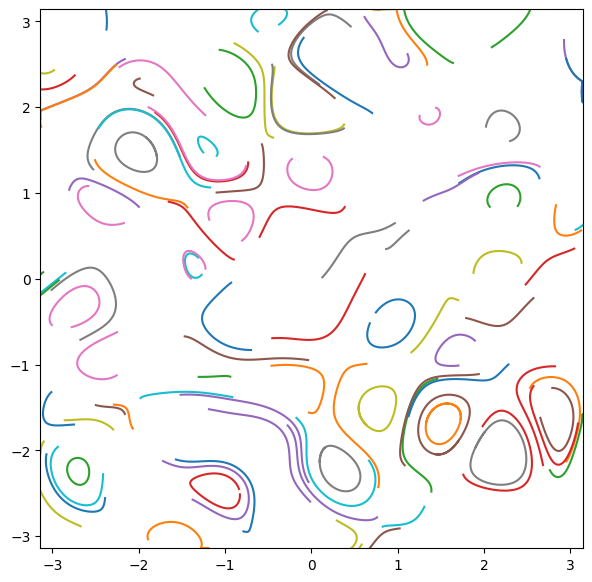

In [ ]:
#Plot the trajectories

plt.figure(figsize=(7, 7))


for sol in solutions:
  plt.plot(sol[:,0],sol[:,1])

plt.xlim(-np.pi, np.pi)
plt.ylim(-np.pi, np.pi)
plt.show()
